# RADIAN Testing

This notebook contains some experiments relating to the operation of the RADIAN spatial data generator. The aim of this is to establish areas of the tool that can be improved, in particular the efficiency and speed of the points generation process itself.

First we'll load the necessary Python packages for some simple points generation with a given **.GeoJSON** polygon file.

In [2]:
# Package imports
import random
from random import randint

import os
import math
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import warnings
from shapely.geometry import Point, Polygon, LineString
from geojson import FeatureCollection

In [104]:


def uniform_points_generation(polygon, number_points):
    # Calculate max and min bounding regions for points
    min_x, min_y, max_x, max_y = polygon.bounds
    #cx, cy = polygon.centroid.x, polygon.centroid.y

    points = []
    accepted = 0 
    rejected = 0
    
    while len(points) < number_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        # Once points lie within the polygon, they are appended to the list
        if (random_point.within(polygon)):
            points.append(random_point)
            accepted += 1
        else:
            rejected += 1

    # List of points is converted to a GeoDataFrame
    df = pd.DataFrame(points, columns=['geometry'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf = gdf.set_crs(epsg=3857)

    return gdf, accepted, rejected

def plot_poly_with_points(polygon, points_df, plot_title):
    fig, ax = plt.subplots(figsize=(6,6))
    polygon = polygon.to_crs(epsg=3857)
    points_df = points_df.to_crs(epsg=3857)
    polygon.plot(ax=ax, facecolor="none", edgecolor='red')
    points_df.plot(ax=ax, markersize=1, color='red', edgecolor='black')
    
    cx.add_basemap(ax, attribution=False)
    ax.set_title(plot_title)
    ax.axis("off")
    plt.axis('equal')
    plt.show()

def poly_around_point(origin=Point([0,0]), shape_type='circle', radius=2500, crs=3857):
    origin = origin.to_crs(crs)
    origin = origin['geometry'][0]
    if shape_type == 'circle':
        shape = origin.buffer(radius)
        shape_df = pd.DataFrame(shape, columns=['geometry'])
        shape_gdf = gpd.GeoDataFrame(shape_df, crs=crs, geometry='geometry')
        print(shape_gdf)
    elif shape_type == 'square':
        origin = origin['geometry'][0]
        # This distance creates the square within the circular radius
        #square_dist = math.sqrt(radius**2 / 2)
        square_dist = radius
        p1 = Point(origin.x - square_dist, origin.y - square_dist)
        p2 = Point(origin.x - square_dist, origin.y + square_dist)
        p3 = Point(origin.x + square_dist, origin.y + square_dist)
        p4 = Point(origin.x + square_dist, origin.y - square_dist)
        point_list = [p1, p2, p3, p4]
        shape_geom = Polygon([[p.x, p.y] for p in point_list])
        shape_gdf = gpd.GeoDataFrame(index=[0], crs=f'epsg:{crs}', geometry=[shape_geom])
    elif shape_type == 'triangle':
        p1 = Point(origin.x - radius, origin.y)
        p2 = Point(origin.x + radius, origin.y + radius)
        p3 = Point(origin.x + radius, origin.y - radius)

        point_list = [p1, p2, p3]
        shape_geom = Polygon([[p.x, p.y] for p in point_list])
        shape_gdf = gpd.GeoDataFrame(index=[0], crs=f'epsg:{crs}', geometry=[shape_geom])

    shape_gdf.to_file(filename=f'scenarios/shape_testing/{shape_type}_test.geojson', driver='GeoJSON')

def get_poly_area(polygon):
    print(str(round(polygon.area[0]/10000, 2)) + "Km^2")

def plot_poly(filename, crs):
    polygon = gpd.read_file(filename)
    print("Polygon info:\n")
    print(polygon)
    fig, ax = plt.subplots(figsize=(6,6))
    polygon.plot(ax=ax, facecolor="none", edgecolor='red')
    cx.add_basemap(ax, attribution=False)
    ax.axis("off")
    plt.axis('equal')
    plt.show()

def radian_lite(poly_filename, number_points, plot):
    print("Running RADIAN-lite...")
    print("#"*85)

    # Load source polygon
    print(f"\tReading {poly_filename}...")
    source_polygon = gpd.read_file(poly_filename)
    #source_polygon = source_polygon.to_crs(epsg=3857)
    print(f"\t{poly_filename} loaded as source polygon.")
    get_poly_area(source_polygon)    
    print("#"*85)

    # Generate points within polygon
    print(f"\tGenerating {number_points} points within the given polygon...")
    uniform_points_gdf, accepted_points, rejected_points = uniform_points_generation(source_polygon['geometry'][0], number_points=500)
    print(f"\tPoints generated successfully.")
    print(f"\t\t{accepted_points} accepted points.\n\t\t{rejected_points} rejected points")
    print("#"*85)

    if plot:
        # Plotting points
        print(f"\tPlotting generated points with source polygon...")
        plot_title = f"{number_points} points generated in source polygon:"
        plot_poly_with_points(source_polygon, uniform_points_gdf, plot_title)
        print(f"\tPoints plotted.")
        print("#"*85)

    print("RADIAN generation complete.")


circle_df = pd.DataFrame([Point([-6.5991454, 53.382711])], columns=['geometry'])
circle_centre = gpd.GeoDataFrame(circle_df, crs=4326, geometry='geometry')
#poly_around_point(origin=circle_centre, shape_type='triangle')
#plot_poly("scenarios/shape_testing/circle_test.geojson", 3857)
get_poly_area(gpd.read_file("scenarios/shape_testing/square_test.geojson"))
get_poly_area(gpd.read_file("scenarios/shape_testing/circle_test.geojson"))
get_poly_area(gpd.read_file("scenarios/shape_testing/triangle_test.geojson"))



2500.0Km^2
1960.34Km^2
1250.0Km^2


C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")
C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")
C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")


In [105]:
radian_lite("scenarios/shape_testing/circle_test.geojson", 100, plot=False)
radian_lite("scenarios/shape_testing/square_test.geojson", 100, plot=False)
radian_lite("scenarios/shape_testing/triangle_test.geojson", 100, plot=False)


Running RADIAN-lite...
#####################################################################################
	Reading scenarios/shape_testing/circle_test.geojson...
	scenarios/shape_testing/circle_test.geojson loaded as source polygon.
1960.34Km^2
#####################################################################################
	Generating 100 points within the given polygon...
	Points generated successfully.
		500 accepted points.
		148 rejected points
#####################################################################################
RADIAN generation complete.
Running RADIAN-lite...
#####################################################################################
	Reading scenarios/shape_testing/square_test.geojson...
	scenarios/shape_testing/square_test.geojson loaded as source polygon.
2500.0Km^2
#####################################################################################
	Generating 100 points within the given polygon...
	Points generated successfully.
		500 ac

C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")
C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")
C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")


## Improving the Generation Process

### The current method:
* Point co-ordinates are generated randomly (using the Pyhton `random` package) from a uniform distribution, with the possible x/y (lat/lon) values being bound by the max and min values given by the bounding box of the source polygon
* The fixed max and minimum values results in points being generated outside of the source polygon, but within the bounding box of the polygon, thus they are rejected and not included in the final dataframe.
### How to fix this
* One method would be to dynamically adjust the max/min ranges for the generated co-ordinates, depending on what stage of the generation RADIAN is at. The generation of X and Y could be adjusted so that rather than simply generating from a uniform distribution between a set max and min...
* Using a trasformaton that would map a given point in a fixed plane (i.e. the bounding box of the source polygon) to points in the polygon itself. That is to say, a point generated outside of the bounds of the polygon, but within the bounding box, would be mapped/transformed to have it's coordinates lie inside the polygon instead.


	Reading scenarios/Kildare/kildare.geojson...
Transforming to EPSG:3857...
EPSG:3857
Equation of the line: y = 0.5455269275047617x + 7432817.052479367


c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


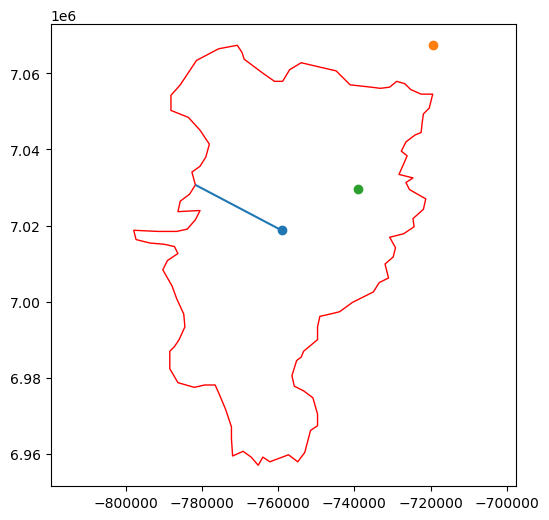

In [18]:
# test with an actual radian generation

def circular_points_generation(polygon, number_points):
    # Calculate max and min bounding regions for points
    min_x, min_y, max_x, max_y = polygon.bounds
    cent_x, cent_y = polygon.centroid.x, polygon.centroid.y

    points = []
    accepted = 0 
    rejected = 0
    
    while len(points) < number_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        # Once points lie within the polygon, they are appended to the list
        if (random_point.within(polygon)):
            points.append(random_point)
            accepted += 1
        else:
            rejected += 1

    # List of points is converted to a GeoDataFrame
    df = pd.DataFrame(points, columns=['geometry'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf = gdf.set_crs(epsg=3857)

    print("Accepted points:", accepted)
    print("Rejected points:", rejected)

    return gdf

def get_equation_between(a, b):
    # y = mx + c
    m = (b.y - a.y) / (b.x - a.x)
    # c = y - mx
    c = b.y - m*b.x

def points_rotation():
    # x_new = x*cos(theta) + y*sin(theta)
    # y_new = -x*sin(theta) + y*cos(theta)
    return

def points_along_line(line, points):
    points = []
    a = Point(line.coords[0])
    b = Point(line.coords[1])
    min_x = a.x
    max_x = b.x

    # y = mx + c
    m = (b.y - a.y) / (b.x - a.x)
    # c = y - mx
    c = b.y - m*b.x

    print(f"Equation of the line: y = {m}x + {c}")

    rand_x = random.uniform(min_x, max_x)
    random_point = Point([rand_x, m*rand_x + c])

    """
    while len(points) < number_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        # Once points lie within the polygon, they are appended to the list
        if (random_point.within(polygon)):
            points.append(random_point)
            accepted += 1
        else:
            rejected += 1
    """

    return random_point

def radial_test(points = 100, poly_filename="scenarios/shape_testing/circle_test.geojson", plot=False):
    # Load source polygon
    print(f"\tReading {poly_filename}...")
    source_polygon = gpd.read_file(poly_filename)
    if source_polygon.crs == 'epsg:4326':
        print("Transforming to EPSG:3857...")
        source_polygon = source_polygon.to_crs(epsg=3857)
    print(source_polygon.crs)

    perimeter_points = list(source_polygon['geometry'][0].exterior.coords)
    
    source_origin = source_polygon.centroid[0]
    cent_x, cent_y = source_origin.x, source_origin.y
    source_bounds = source_polygon.bounds

    source_radius = math.sqrt((source_bounds['maxx'])**2 + (source_bounds['maxy'])**2)
    
    max_point = Point([source_bounds['maxx'], source_bounds['maxy']])

    test_lines = []
    for i in range(720):
        theta = (2*math.pi)/360
        x_new = ((max_point.x-cent_x) * math.cos(theta)) - ((max_point.y-cent_y) * math.sin(theta))
        y_new = ((max_point.x-cent_x) * math.sin(theta)) + ((max_point.y-cent_y) * math.cos(theta))
        rand_perim_point = Point(perimeter_points[random.randint(0, len(perimeter_points)-1)])
        test_line = LineString([source_origin, rand_perim_point])
        test_lines.append(test_line)
    
    lines_gdf = gpd.GeoDataFrame(pd.DataFrame(test_lines, columns=['geometry']), crs=3857, geometry='geometry')

    point_test = points_along_line(test_line, 100)

    lines_difference = lines_gdf.difference(source_polygon)

    if plot:
        fig, ax = plt.subplots(figsize=(6,6))
        source_polygon.plot(aspect=1, ax=ax, facecolor="none", edgecolor='red')
        gpd.GeoSeries(source_origin).plot(aspect=1, ax=ax)
        gpd.GeoSeries(lines_gdf['geometry'][0]).plot(aspect=1, ax=ax)
        gpd.GeoSeries(max_point).plot(aspect=1, ax=ax)
        gpd.GeoSeries(point_test).plot(aspect=1, ax=ax)
        lines_difference.plot(aspect=1, ax=ax)
        #cx.add_basemap(ax, attribution=False)
        #ax.axis("off")
        plt.axis('equal')
        plt.show()

radial_test(poly_filename="scenarios/Kildare/kildare.geojson", plot=True)
